# Support Vector Machines

* Support vector machine (SVM) is a class of supervised algorithms for both classification and regression.
* We will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

* We learned that Bayesian classification is a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
* Bayesian classification is an example of *generative classification*; 
* In SVM, we will consider instead *discriminative classification*: we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

* As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated
* We will use the sklearn function  [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) to generate sample points

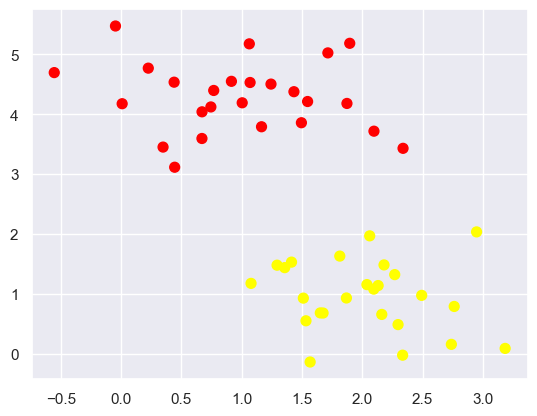

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

* A *linear discriminative classifier* would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
* For two dimensional data like that shown here, this is a task we could do by hand.
* Problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows ([np.linspace()](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linspace.html)  function returns num evenly spaced samples, calculated over the interval \[start, stop\])

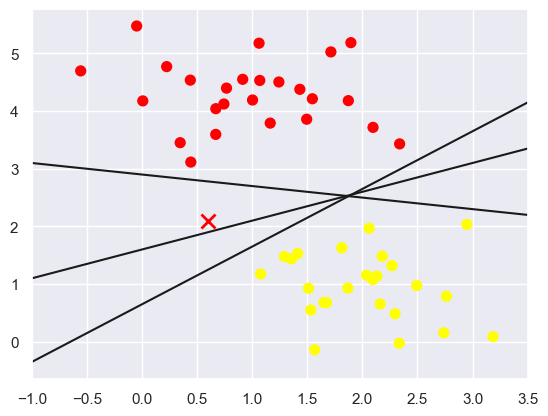

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

*  Three *very* different separators which perfectly discriminate between these samples.
* Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
* Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

* Support vector machines offer one way to improve on this.
* The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
* Here is an example of how this might look:

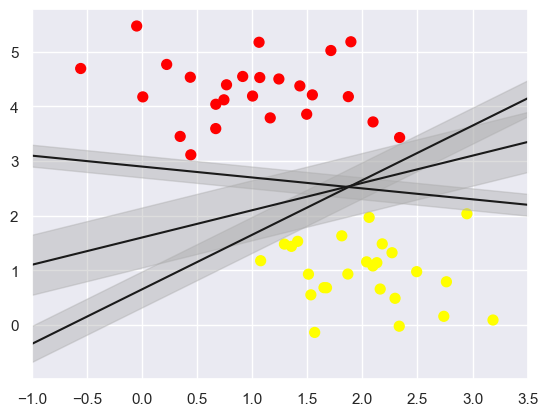

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

* In SVM, the line that maximizes this margin is the one we will choose as the optimal model.
* Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

* Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to train an SVM model on this data.
* For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

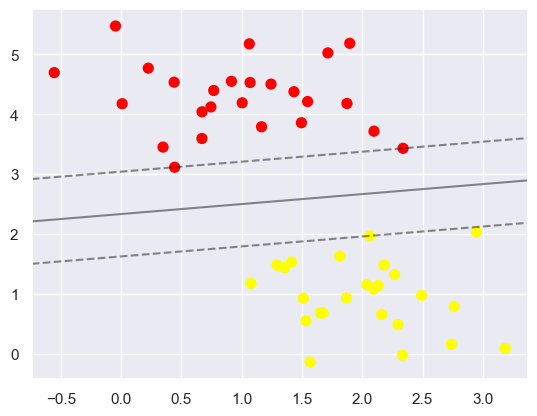

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

* This is the dividing line that maximizes the margin between the two sets of points.
* Notice that a few of the training points just touch the margin
* These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
* In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

* A key to this classifier's success is that for the fit, only the position of the support vectors matter
* Any points further from the margin which are on the correct side do not modify the fit!

* We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

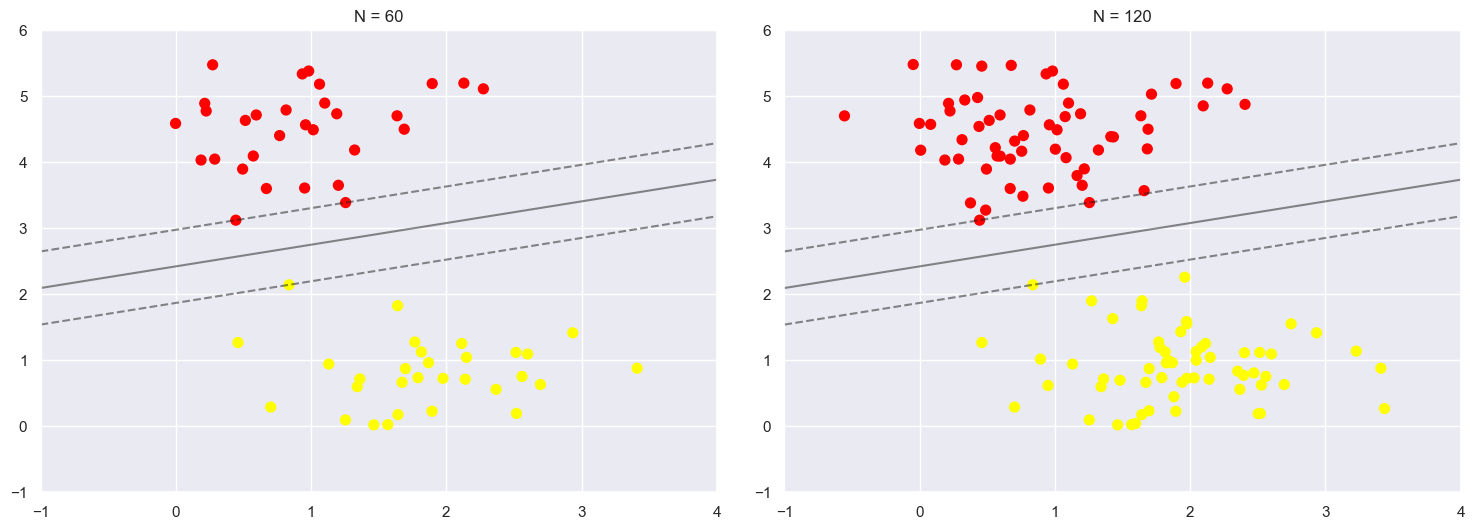

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

* In the left panel, we see the model and the support vectors for 60 training points.
* In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
* This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets [interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html) to view this feature of the SVM model interactively:

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 100, 200,300], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 100, 200, 300), value=10), Output()), _dom_classe…

### Beyond linear boundaries: Kernel SVM

* SVM becomes extremely powerful when it is combined with *kernels*
* To motivate the need for kernels, let's look at some data that is not linearly separable using the function [make_circles()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html)

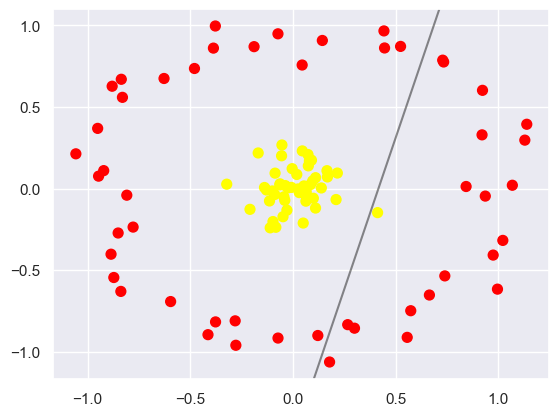

In [11]:
from sklearn.datasets import make_blobs, make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

* It is clear that no linear discrimination will *ever* be able to separate this data.
* We can think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
* For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [12]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot

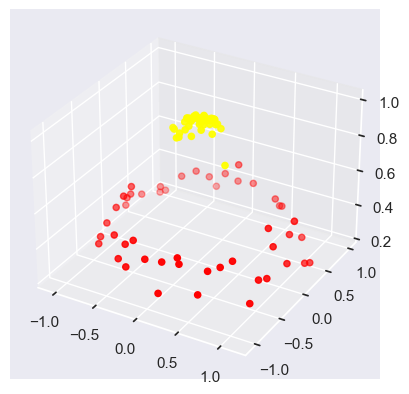

In [13]:
from mpl_toolkits.mplot3d import axes3d
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, cmap='autumn');

* We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

* Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
* In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

* One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
* This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

* A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
* However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
* This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

* In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [14]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

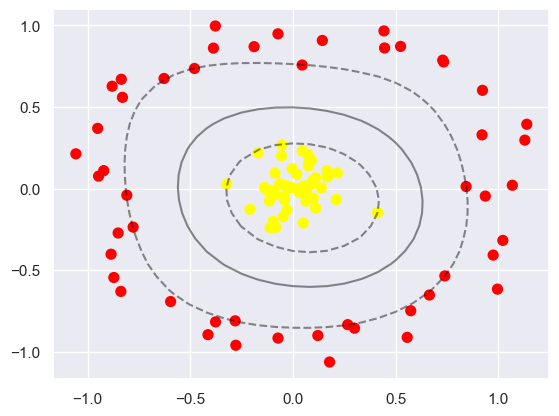

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

* Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
* This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

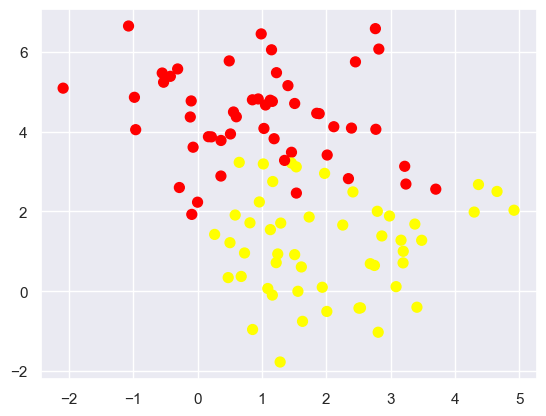

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

* To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
* The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
* For very large $C$, the margin is hard, and points cannot lie in it.
* For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

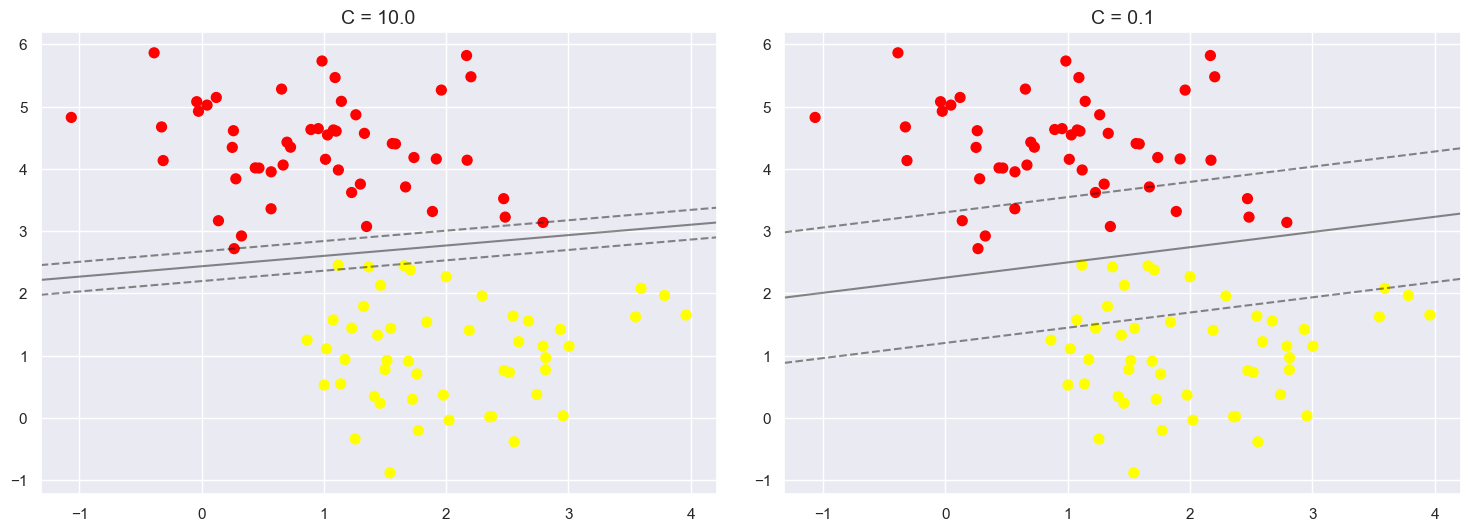

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned.

sklearn provides a number of predefined kernels

<ol>
    <li>Linear</li>
    <li>Polynomial</li>
    <li>Radial Basis Function</li>
    <li>Sigmoid</li>
</ol>

In [18]:
model = SVC(kernel="poly", degree="3")

In [19]:
model = SVC(kernel="rbf", gamma=0.01)

In [20]:
model = SVC(kernel="sigmoid", gamma=0.01, coef0=1)

## Example: Recognizing hand-written digits
The data that we are interested in is made of 8x8 images of digits, let's have a look at the first 4 images, stored in the `images` attribute of the dataset.  If we were working from image files, we could load them using matplotlib.pyplot.imread.  Note that each image must have the same size. For these images, we know which digit they represent: it is given in the 'target' of the dataset.

Automatically created module for IPython interactive environment


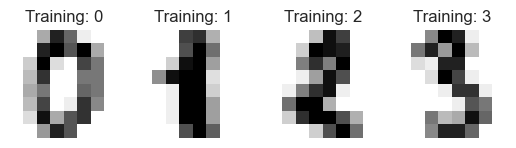

In [21]:
print(__doc__)

# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# License: BSD 3 clause

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# We learn the digits on the first half of the digits
classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])

# Now predict the value of the digit on the second half:
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])



In [22]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))


Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




Text(110.44999999999997, 0.5, 'true value')

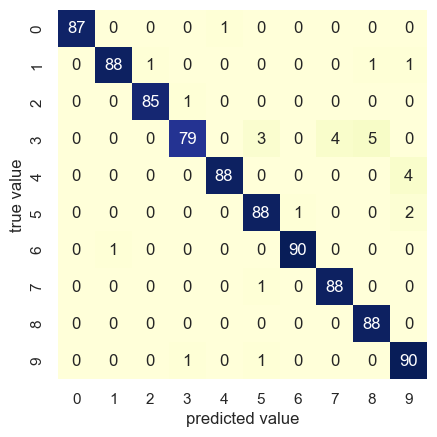

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

mat = metrics.confusion_matrix(expected, predicted)

sns.heatmap(mat, square = True, annot = True, cmap="YlGnBu",cbar = False)
plt.xlabel('predicted value')
plt.ylabel('true value')

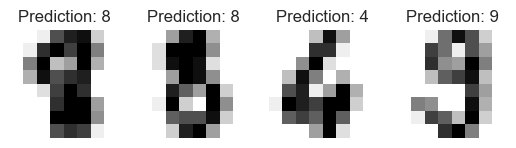

In [24]:
images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)

plt.show()

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. 
- The results do not have a direct probabilistic interpretation. 



*This notebook was adapted from  the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

## Hyperparameter Tuning

### Load the iris dataset using seaborn

In [42]:
import seaborn as sns
iris = sns.load_dataset('iris')

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Train test split

In [44]:
from sklearn.model_selection import train_test_split
X = iris.drop('species',axis=1)
y = iris['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Train using SVM

In [45]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC()

### Model evaluation

In [46]:
predictions = svc_model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))

[[14  0  0]
 [ 0 15  0]
 [ 0  3 13]]


In [47]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        14
  versicolor       0.83      1.00      0.91        15
   virginica       1.00      0.81      0.90        16

    accuracy                           0.93        45
   macro avg       0.94      0.94      0.94        45
weighted avg       0.94      0.93      0.93        45



### Improving results using GridSearchCV
Finding the right parameter values (such as for C and gamma) could be tricky. Experimenting on the right combination of values systematically can be done using GridSearchCV.

GridSearchCV takes a dictionary as input that describes the parameters that should be tested and a model to train. The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

### Import GridSearchCV from sklearn

In [48]:
from sklearn.model_selection import GridSearchCV

### Create a dictionary called param_grid and fill out some parameters such as for C and gamma

In [49]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

### Create a GridSearchCV object and fit it to the training data.

In [51]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.1

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=2)

You can inspect the best parameters found by GridSearchCV in the best_params_ attribute, and the best estimator in the best\_estimator_ attribute:

In [52]:
grid.best_params_

{'C': 10, 'gamma': 0.1}

In [53]:
grid.best_estimator_

SVC(C=10, gamma=0.1)

### Use the selected grid model

In [54]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))

[[14  0  0]
 [ 0 15  0]
 [ 0  1 15]]


In [55]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        14
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.94      0.97        16

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45

